# **Using pipeline**

In [58]:
!pip install -Uq diffusers transformers 

In [59]:
import torch

import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
# from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [60]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

In [61]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [73]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [74]:
from diffusers import LMSDiscreteScheduler

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [75]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

In [76]:
text_input = tokenizer(prompts, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_emb = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [77]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * len(prompts), padding="max_length", max_length=max_length, return_tensors="pt")
uncond_emb = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
emb = torch.cat([uncond_emb, text_emb])

In [78]:
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [79]:
torch.manual_seed(100)
g = guidance_scale

In [80]:
latents = torch.randn((len(prompts)),  unet.in_channels, height//8, width//8)
scheduler.set_timesteps(num_inference_steps)
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

<ipython-input-80-074dfe9dc7e9>:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((len(prompts)),  unet.in_channels, height//8, width//8)


In [81]:
from tqdm.auto import tqdm


for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [82]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

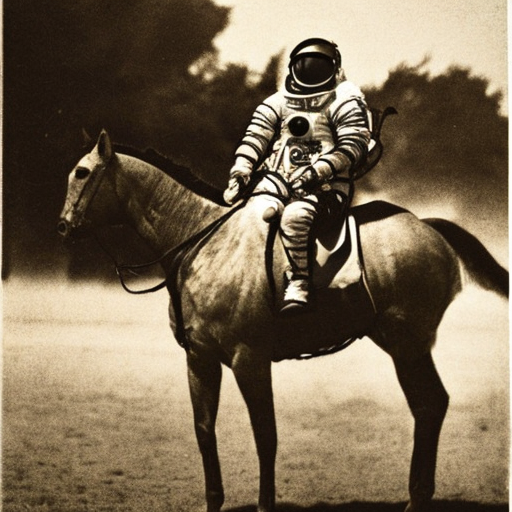

In [83]:
image = res[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

# **Making functions**

In [84]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [85]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [91]:
prompts1 = [
    'Keanu Reeves portrait photo of a asia old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta',
    'portrait photo of a african old warrior chief, tribal panther make up, gold on white, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta'
]

In [92]:
images = mk_samples(prompts1)

<ipython-input-85-63505bebb644>:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

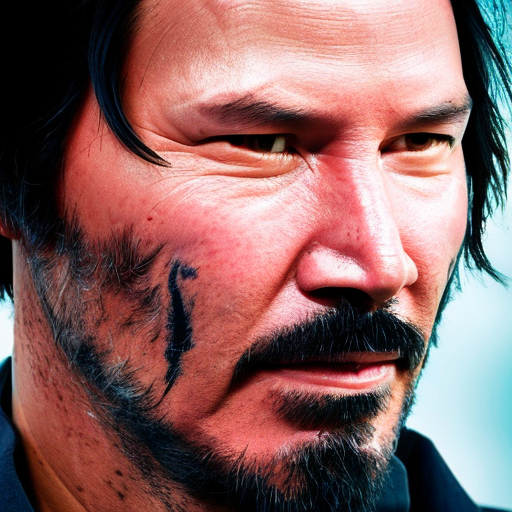

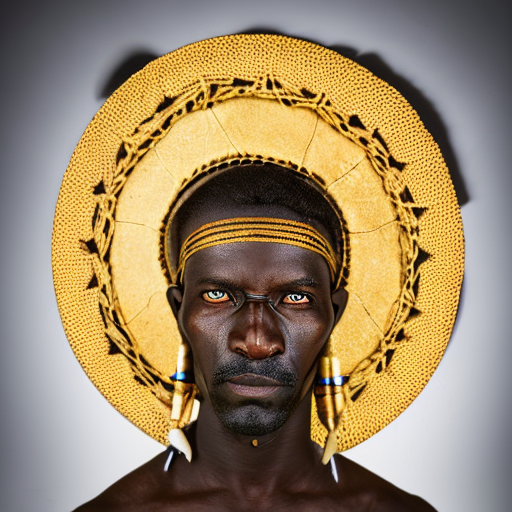

In [93]:
from IPython.display import display

for img in images: display(mk_img(img))